In [1]:
from paretoset import paretoset
import pandas as pd 
import numpy as np
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib
from scipy.spatial import distance
from utils import *

## Configurations and settings

In [2]:
# benchmarks = {"transcode": "cats-1", "pigo-faceblur": "faces2", "pigo-face-detector": "faces2", "openfaas-ocr": "doc", "linpack": "2500", "s3": "cats-1"}
calculate_cpu_mem_costs()

benchmark_naming = {"transcode": "transcode", "pigo-faceblur": "faceblur", "pigo-face-detector": "facedetect", "classifier": "classifier", "linpack": "linpack", "s3": "s3", "openfaas-ocr": "ocr"}

benchmarks ={"transcode": "cats-1"}

base_estimator = 'GP'
CPU_LIMITS= [ '250m', '500m', '750m', '1000m', '1250m', '1500m', '1750m', '2000m' ]
MEMORY_LIMITS=[ '128Mi', '256Mi', '512Mi', '768Mi', '1024Mi', '2048Mi' ]
instance_types = ['m5', 'm5a', 'c5', 'c5a', 'c6g', 'm6g']

N_TRIALS = 20
N_INIT_SAMPLES = 3
N_OPT_TRAILS = 10

data_dir = 'analysis_data/'

## Helper functions

In [6]:
def train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='runtime'):
    if base_estimator != "poly":
        from optimizer.boskopt import Models
        model = Models()
        model.create_model(function=function_name, base_estimator=base_estimator)
    else:
        from optimizer.polyreg import Models
        model = Models()
        model.create_model(function=function_name)

    runtimes = []
    costs = []

    minimum = 600.0
    best_config = {}

    init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
    # init_samples = get_init_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES, var=True)

    default_config = init_samples[0]
    config = default_config
    # print(config)

    if base_estimator != "poly":
        from optimizer.boskopt import Models
        model = Models()
        model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
    else:
        from optimizer.polyreg import Models
        model = Models()
        model.create_model(function=function_name)

    for i in range(0, N_TRIALS):
        success = True

        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        # runtimes.append(result)

        if result < minimum:
            minimum = result
            best_config = config 
        # print(result, config)

        model.update(config, result, function_name, success=True)
        
        if i < N_INIT_SAMPLES-1:
            config = init_samples[i+1]
        else:
            config = model.get_next_config(function_name)
        
    return model, best_config 

In [ ]:
model_perf = pd.DataFrame(columns=["benchmark", "trials", "instance type", "Norm. Value", "type"])
ideal_perf = pd.DataFrame(columns=["benchmark", "trials", "instance type", "Norm. Value", "type"])
for function_name in benchmarks.keys():
    print(function_name)

    data_name = benchmarks[function_name]
    # minimum_cost, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='cost')
    minimum_runtime, actual_best_config_cost,_ ,_ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='1.0/0.0')
    
    for x in range(0, N_OPT_TRAILS):
        runtimes = []
        costs = []
        configs = []

        model, best_config = train_model(x, CPU_LIMITS, MEMORY_LIMITS, instance_types, N_INIT_SAMPLES, function_name, data_name, metric='runtime')
        best_found_config_runtime = get_result_from_data(function_name, data_name, best_config, MEMORY_LIMITS)
        best_found_config_cost = get_result_from_data(function_name, data_name, best_config, MEMORY_LIMITS, metric='cost')

        predictions = model.get_top_across_types(function_name)

        # Retraining...
        for prediction in predictions:
            conf = prediction[1]
            config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
            runtime = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS)

            model.update(config, runtime, function_name, success=True)
        predictions = model.get_top_across_types(function_name)

        # print(predictions)

        data_top_per_type = get_top_per_type_configs_from_data(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='runtime')

        data_top_per_type = sorted(data_top_per_type, key=lambda x: x[0])
        # print(data_top_per_type)

        best_inst = data_top_per_type[0][1][0]

        # For the optimization model 
        for prediction in predictions:
            if prediction[1][0] == best_inst:
                print(prediction)
                continue

            conf = prediction[1]
            config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
            cost = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='cost') * 0.2

            if prediction[0] <= best_found_config_runtime * 1.1:
                print(config)
                model_perf = model_perf.append({'benchmark': function_name, 'trials': x, 'instance type': conf[0], 'Norm. Value': cost/best_found_config_cost, 'type': "xt-EC"}, ignore_index=True)

                runtime = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS) 
                print(best_found_config_runtime, prediction[0], runtime)
                model_perf = model_perf.append({'benchmark': function_name, 'trials': x, 'instance type': conf[0], 'Norm. Value': runtime/best_found_config_runtime, 'type': "xt-ET"}, ignore_index=True)
            else:
                model_perf = model_perf.append({'benchmark': function_name, 'trials': x, 'instance type': conf[0], 'Norm. Value': 1, 'type': "xt-EC"}, ignore_index=True)
                model_perf = model_perf.append({'benchmark': function_name, 'trials': x, 'instance type': conf[0], 'Norm. Value': 1, 'type': "xt-ET"}, ignore_index=True)

        # For the ideal case
        # for c in data_top_per_type:
        #     if c[1][0] == best_inst:
        #         continue 
        #     conf = c[1]
        #     config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        #     cost = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='cost') * 0.2

        #     if c[0] <=  minimum_runtime * 1.1:
        #         ideal_perf = ideal_perf.append({'benchmark': function_name, 'trials': x, 'instance type': conf[0], 'Norm. Value': cost/actual_best_config_cost, 'type': "EC"}, ignore_index=True)

        #         ideal_perf = ideal_perf.append({'benchmark': function_name, 'trials': x, 'instance type': conf[0], 'Norm. Value': c[0]/minimum_runtime, 'type': "ET"}, ignore_index=True)
                
        #     else:
        #         ideal_perf = ideal_perf.append({'benchmark': function_name, 'trials': x, 'instance type': conf[0], 'Norm. Value': 1, 'type': "EC"}, ignore_index=True)
        #         ideal_perf = ideal_perf.append({'benchmark': function_name, 'trials': x, 'instance type': conf[0], 'Norm. Value': 1, 'type': "ET"}, ignore_index=True)


        # print(gains)

# model_perf.to_csv(data_dir + 'alternatives-model.csv', index=False, mode='a', header=False)
# ideal_perf.to_csv(data_dir + 'alternatives-ideal.csv', index=False)

        # calculate_cpu_mem_costs(pricing_model='spot', instance_types=[types[i]])

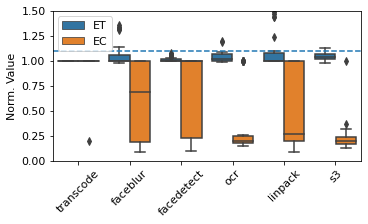

In [3]:
matplotlib.rcParams.update({'font.size': 11})

model_perf = pd.read_csv(data_dir + 'alternatives-model.csv')
ideal_perf = pd.read_csv(data_dir + 'alternatives-ideal.csv')

model_perf.replace(benchmark_naming, inplace=True)
ideal_perf.replace(benchmark_naming, inplace=True)

fig = plt.figure(figsize=(5, 3), constrained_layout=True)
# fig, axs = plt.subplots(figsize=(10, 4), ncols=2, constrained_layout=True)
model_perf = model_perf[model_perf['type']!="xt-EC"]
model_perf = model_perf[model_perf['type']!="xt-ET"]

hue_order = ['ET', 'EC']
ax = sns.boxplot(data=model_perf, x='benchmark', y='Norm. Value', hue='type', hue_order=hue_order)#, ax=axs[0])#, estimator=np.median)
ax.legend(ncol=1)
ax.set_ylim(0, 1.5)
# ax.set_title('(a)')
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.label.set_visible(False)
ax.axhline(1.1, ls='--')

# ax = sns.boxplot(data=ideal_perf, x='benchmark', y='Norm. Value', hue='type', ax=axs[1])#, estimator=np.median)
# ax.set_ylim(0, 1.5)
# ax.legend().set_visible(False)
# ax.tick_params(axis='x', labelrotation=45)
# ax.set_title('(b)')
# ax.set_xlabel('Benchmark')
# plt.show()

# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0))
# plt.legend(ncol=1, loc='upper left')
plt.savefig('plots/cost-benefit.pdf', bbox_inches = "tight")